## Домашняя работа #4.


Домашка на использование параметрических моделей.
* Ransac.
* Hough transform.


**Soft deadline: 21.04.2022 03:00:00 +0003 GMT**

**Hard deadline: 28.04.2022 03:00:00 +0003 GMT**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

# RANSAC

Ниже приведены блоки кода с помощью которых можно склеивать панорамы в единую картинку. 
* Извлекаем ключевые точки
* Сопоставляем похожие
* Ищем гомографию
* Склеиваем изображения

Гомография это обычное преобразование одник координат к другим с помощью матрицы. Мы должны с помощью `RANSAC` найти параметры этой матрицы. 
Для этого вы случайно берете `s` точек, по ним оцениваете значения $h_{11}$, .., $h_{33}$ считаете значние ошибки сопоставления на всех точках, etc 

# Скачиваем картинки

In [2]:
# select the image id (valid values 1,2,3, or 4)
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

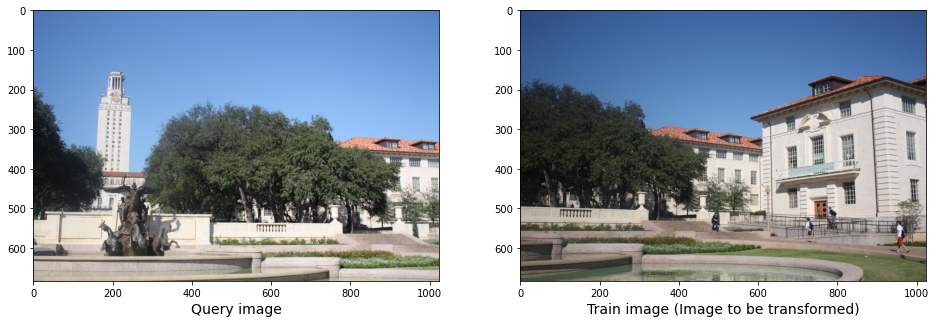

In [3]:
trainImg = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg')
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

queryImg = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg')
# Opencv defines the color channel in the order BGR. 
# Transform it to RGB to be compatible to matplotlib
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

# Ищем ключевые точки и вычисляем дексрипторы

In [4]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

In [5]:
kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)

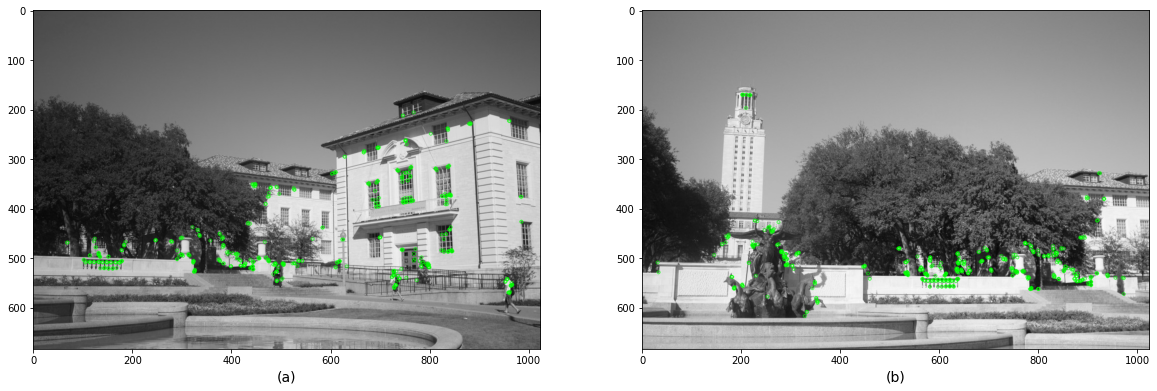

In [6]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

# Ищем похожие дескрипторы

In [7]:
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [8]:
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

In [9]:
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Using: bf feature matcher
Raw matches (Brute force): 189


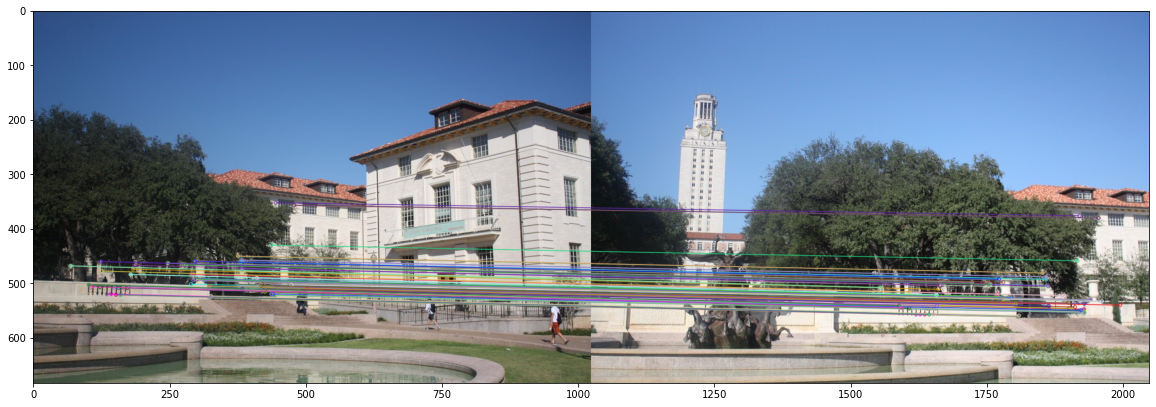

In [10]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.show()

# Сопоставление ключевых точек на изображении

In [11]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [12]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 7.40803245e-01 -4.99883247e-02  4.60620696e+02]
 [-1.15882069e-01  7.98230472e-01  1.00867120e+02]
 [-1.78934909e-04 -1.49752313e-04  1.00000000e+00]]


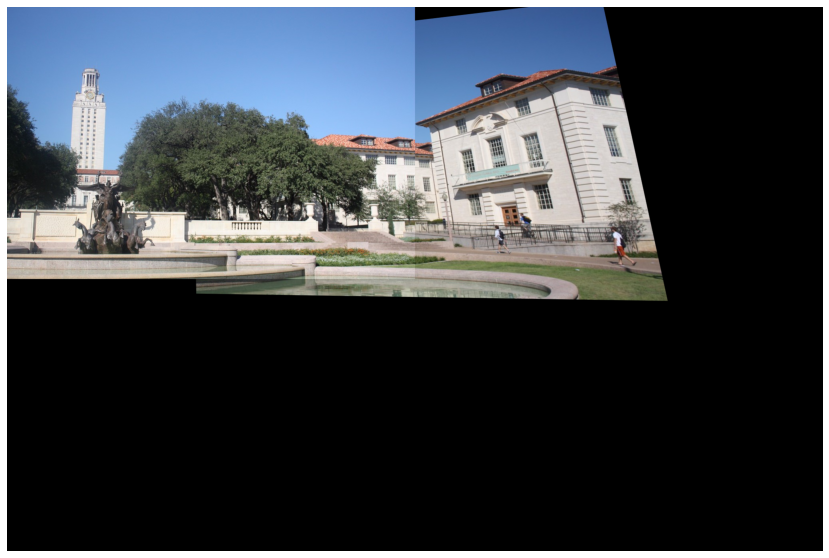

In [13]:
# Apply panorama correction
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

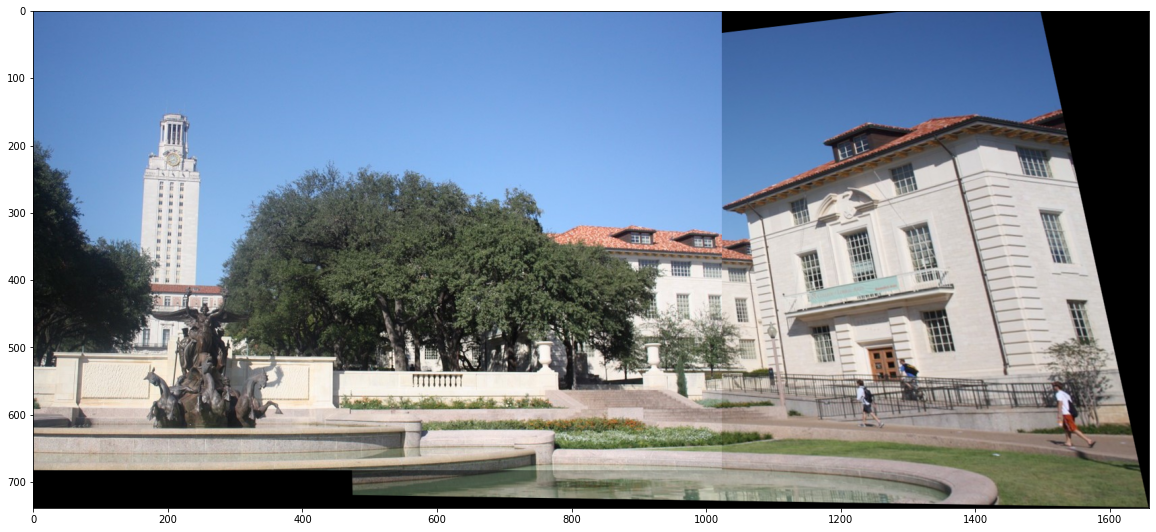

In [14]:
# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)

**Задание 1. (20 баллов)**

Напишите свою функцию `findHomography` , которая принмает на вход список сопоставленных точек и использует `RANSAC` для определния матрицы гомографии. Примените вашу функцию и сравните результат. Склейте панораму используя матрицу гомографии. `RANSAC` тоже нужно имплементировать самостоятельно. 

In [15]:
def findHomography(kpsA, kpsB, matches, s=4, reprojThresh=4.0,
                   num_iterations=100, use_all=False):
    if len(matches) <= s:
        return None

    # find coordinates of matched points
    ptsA = np.float32([kpsA[m.queryIdx].pt for m in matches])
    ptsB = np.float32([kpsB[m.trainIdx].pt for m in matches])

    return ransac(ptsA, ptsB, s, reprojThresh, num_iterations, use_all)


def ransac(ptsA: np.ndarray, ptsB: np.ndarray, s: int = 4,
           reprojThresh: float = 4.0, num_iterations: int = 100,
           use_all=False):
    n = len(ptsA)
    assert len(ptsB) == n
    H_best = np.zeros((3, 3), dtype='float32')
    outliers_best = len(ptsA)
    inliers = np.arange(0)

    # outer loop: try num_iterations random permutations
    for _ in range(num_iterations):
        inds = np.random.permutation(range(n))
        i1, i2 = 0, s
        while i2 <= n:
            # find homography matrix by least squares
            inds_in = inds[i1:i2]
            H = estimate_homography(ptsA[inds_in], ptsB[inds_in])

            # check the number of outliers
            inds_out = np.concatenate([inds[:i1], inds[i2:]])
            pred = transform(ptsA[inds_out], H)
            distances = np.sqrt(np.sum((ptsB[inds_out] - pred)**2, axis=1))
            mask = (distances <= reprojThresh)
            outliers_cur = (~mask).sum()
            if outliers_cur < outliers_best:
                H_best = H
                outliers_best = outliers_cur
                inliers = np.concatenate([inds_in, inds_out[mask]])

            # update indices
            i1 = i2
            i2 = i1 + s

    # recalculate homography matrix using all inliers
    if use_all:
        H_best = estimate_homography(ptsA[inliers], ptsB[inliers])
    return H_best


def estimate_homography(src, dst):
    A = []
    for (x1, y1), (x2, y2) in zip(src, dst):
        A.append([-x1, -y1, -1, 0, 0, 0, x2 * x1, x2 * y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, x1 * y2, y1 * y2, y2])
    A = np.array(A)
    _, _, v = np.linalg.svd(A)
    return v[-1].reshape(3, 3).astype('float32')


def transform(src, H):
    inp = np.hstack([src, np.ones((len(src), 1))])
    out = H @ inp.T
    pred = np.zeros((len(src), 2), dtype='float32')
    pred[:, 0] = out[0] / out[2]
    pred[:, 1] = out[1] / out[2]
    return pred

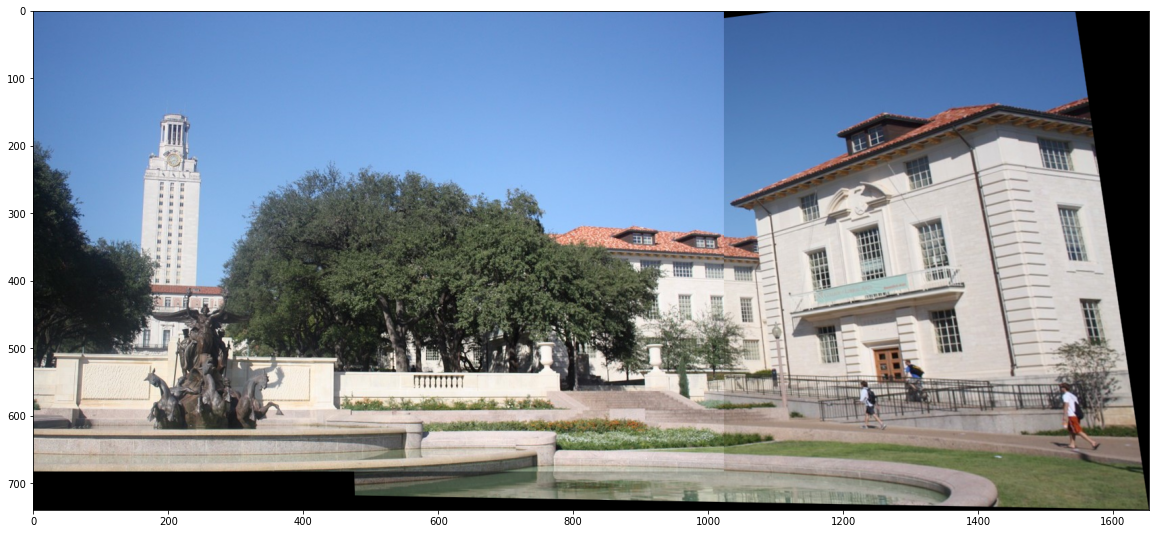

In [16]:
H = findHomography(kpsA, kpsB, matches, s=4, reprojThresh=5.0,
                   num_iterations=100, use_all=True)
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]
result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)

***Новая версия с адаптивным выбором числа итераций***

In [17]:
def findHomography_v2(kpsA,kpsB, matches, s=4,reprojThresh=4.0,
                      num_iterations=None, p=0.99, use_all=False):
    if len(matches) <= s:
        return None

    # find coordinates of matched points
    ptsA = np.float32([kpsA[m.queryIdx].pt for m in matches])
    ptsB = np.float32([kpsB[m.trainIdx].pt for m in matches])

    return ransac_v2(ptsA, ptsB, s, reprojThresh, num_iterations, p, use_all)


def ransac_v2(ptsA, ptsB, s=4, reprojThresh=4.0, num_iterations=None,
              p=0.99, use_all=False):
    n = len(ptsA)
    assert len(ptsB) == n

    # initialization
    H_best = np.zeros((3, 3), dtype='float32')
    outliers_best = len(ptsA)
    inliers = np.arange(0)

    # use adaptive strategy if number of iterations not specified
    if num_iterations is None:
        num_iterations = np.inf
        adaptive = True
    else:
        adaptive = False
    sample_count = 0

    # perform iterations
    while sample_count < num_iterations:
        # split points into 2 subsets
        inds = np.random.permutation(n)
        inds_in = inds[:s]
        inds_out = inds[s:]
        sample_count += 1

        # find homography matrix by least squares
        H = estimate_homography(ptsA[inds_in], ptsB[inds_in])

        # check the number of outliers
        pred = transform(ptsA[inds_out], H)
        distances = np.sqrt(np.sum((ptsB[inds_out] - pred)**2, axis=1))
        mask = (distances <= reprojThresh)
        outliers_cur = (~mask).sum()
        if outliers_cur < outliers_best:
            H_best = H
            outliers_best = outliers_cur
            inliers = np.concatenate([inds_in, inds_out[mask]])
            if adaptive:  # update number of iterations
                e = outliers_best / n
                num_iterations = np.log(1 - p) / np.log(1 - (1 - e)**s)

    # recalculate homography matrix using all inliers
    if use_all:
        H_best = estimate_homography(ptsA[inliers], ptsB[inliers])
    return H_best

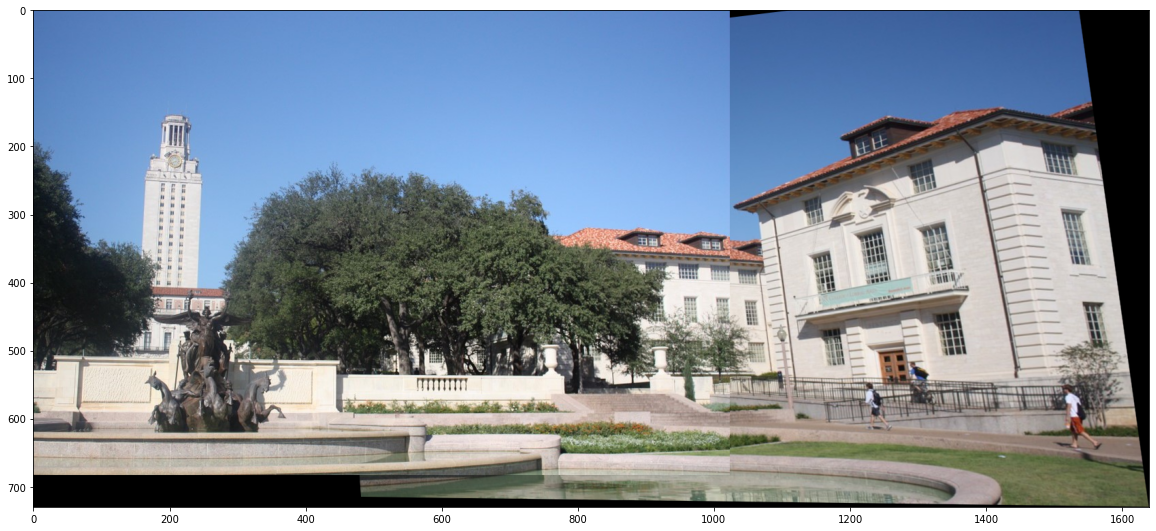

In [18]:
H = findHomography_v2(kpsA, kpsB, matches, s=4, reprojThresh=1.5,
                      num_iterations=None, p=0.9999, use_all=True)
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]
result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)

**Задание 2. (10 баллов)**

Напишите преобразование Хафа для поиска окружностей. Если для прямых мы делали трюк с превращением одного из параметров в cos для того, чтобы он был ограничен, то тут, кажется, нам надо перебрать координаты и всевозможные радиусы.  Примените его для поиска окружнойтей на изображении *сoins_noize_1.jpg* из предыдущего домашнего задания. Если не хотите перебирать руками все радиусы, то можно попробовать вдохновиться [этой работой](https://www.ecse.rpi.edu/~cvrl/Publication/pdf/Xie2002.pdf)

Сравните вашу функцию с функцией `cv.HoughCircles` по времени работы и по качеству. 

In [19]:
import os
import copy
import heapq

In [20]:
def hough_circles(img, threshold,
                  canny_thresh_1=100, canny_thresh_2=200,
                  r_min=5, r_max=None, r_bins=30, min_dist=20):
    img = cv2.Canny(img, canny_thresh_1, canny_thresh_2)
    A, radii = hough_transform(img, r_min, r_max, r_bins)
    return filter_hough_circles(A, radii, threshold, min_dist)


def hough_transform(img, r_min=5, r_max=None, r_bins=30):
    h, w = img.shape
    if r_max is None:
        r_max = min(h, w) // 2
    radii = np.linspace(r_min, r_max, r_bins + 1)
    x0, y0 = np.meshgrid(np.arange(0, w), np.arange(0, h))
    A = np.zeros((h, w, r_bins), dtype='uint32')

    # iterate over pixels
    for i in range(h):
        print(f'Hough transform progress: {i}/{h - 1}', end='\r')
        for j in range(w):
            if img[i, j] == 0:
                continue
            r = np.sqrt((i - y0)**2 + (j - x0)**2)
            for k in range(r_bins):
                mask = (r >= radii[k]) & (r < radii[k + 1])
                A[:, :, k][mask] += img[i, j]
    print()

    # scale accumulator matrix so that values are <= 100
    circ = np.pi * (radii[:-1] + radii[1:])
    A = (A / (circ * 2.55))
    return A, radii


def filter_hough_circles(A, radii, threshold, min_dist=20):
    # sort circles by "intensity"
    heap = []
    ix, iy, ir = np.where(A >= threshold)
    for i, j, k in zip(ix, iy, ir):
        heapq.heappush(heap, (-A[i, j, k], (j, i, radii[k])))

    # remove circles that are too close to ones with higher intensity
    circles = []
    while heap:
        _, (x0, y0, r) = heapq.heappop(heap)
        distances = [np.sqrt((xi - x0)**2 + (yi - y0)**2)
                     for xi, yi, _ in circles]
        if not distances or min(distances) > min_dist:
            circles.append(np.array([x0, y0, r], dtype='uint16'))

    return circles

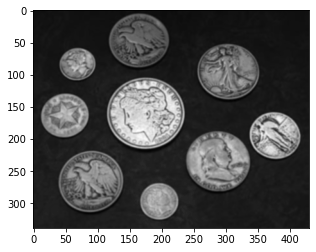

In [21]:
img = cv2.imread(os.path.join(os.getcwd(), 'data', 'coins_1.jpg'))
blur = cv2.GaussianBlur(img, (7, 7), 1)
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

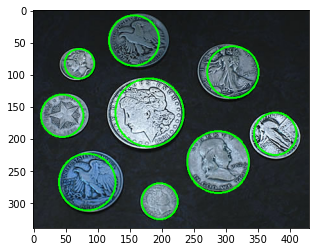

In [22]:
img2 = copy.deepcopy(img)
circles = cv2.HoughCircles(
    gray,
    cv2.HOUGH_GRADIENT,
    dp=1,
    minDist=40,
    minRadius=20,
    maxRadius=60,
    param2=50
)
for circle in circles.squeeze():
    x0, y0, r = np.uint16(circle)
    cv2.circle(img2, (x0, y0), r, (0, 255, 0), thickness=2)
plt.figure()
plt.imshow(img2)

Hough transform progress: 338/338


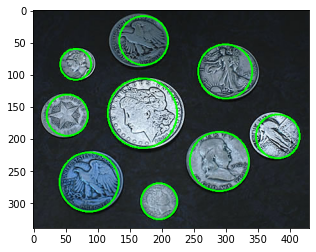

In [23]:
img2 = copy.deepcopy(img)
circles = hough_circles(
    gray,
    threshold=55,
    canny_thresh_1=180,
    canny_thresh_2=220,
    r_min=20,
    r_max=60,
    r_bins=20,
    min_dist=50
)
for circle in circles:
    x0, y0, r = np.uint16(circle)
    cv2.circle(img2, (x0, y0), r, (0, 255, 0), thickness=2)
plt.figure()
plt.imshow(img2)

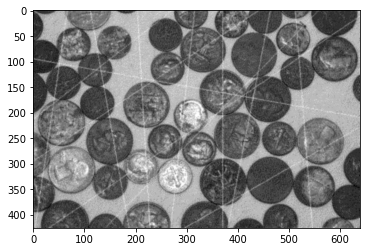

In [24]:
img = cv2.imread(os.path.join(os.getcwd(), 'data', 'coins_noise_2.jpg'))
blur = cv2.GaussianBlur(img, (11, 11), 1)
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

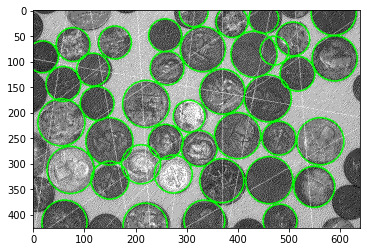

In [25]:
img2 = copy.deepcopy(img)
circles = cv2.HoughCircles(
    gray,
    cv2.HOUGH_GRADIENT,
    dp=1,
    minDist=40,
    minRadius=25,
    maxRadius=50,
    param1=300,
    param2=16
)
for circle in circles.squeeze():
    x0, y0, r = np.uint16(circle)
    cv2.circle(img2, (x0, y0), r, (0, 255, 0), thickness=2)
plt.figure()
plt.imshow(img2)

Hough transform progress: 425/425


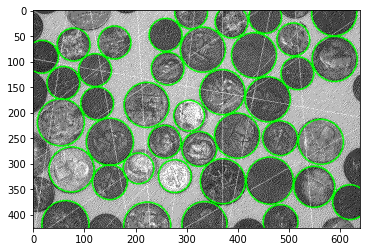

In [26]:
img2 = copy.deepcopy(img)
circles = hough_circles(
    gray,
    threshold=40,
    canny_thresh_1=180,
    canny_thresh_2=220,
    r_min=30,
    r_max=50,
    r_bins=10,
    min_dist=50
)
for circle in circles:
    x0, y0, r = np.uint16(circle)
    cv2.circle(img2, (x0, y0), r, (0, 255, 0), thickness=2)
plt.figure()
plt.imshow(img2)